## Import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D, Bidirectional

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(20) # Seed 고정

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/sangchu

/content/drive/MyDrive/Colab Notebooks/sangchu


In [ ]:
PROJECT_DIR = os.getcwd()
PROJECT_DIR

'/content/drive/MyDrive/Colab Notebooks/sangchu'

In [ ]:
DATA_DIR = os.path.join(PROJECT_DIR, 'sangchu-data')
DATA_DIR

'/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data'

## Data Pre-processing

In [ ]:
all_input_list = sorted(glob.glob(os.path.join(DATA_DIR, 'train_input', '*.csv')))
all_target_list = sorted(glob.glob(os.path.join(DATA_DIR, 'train_target', '*.csv')))
all_input_list

['/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_01.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_02.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_03.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_04.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_05.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_06.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_07.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_08.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_09.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_10.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_11.csv',
 '/content/drive/MyDrive/Colab N

In [ ]:
pd.read_csv(all_input_list[0])

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
3,0,03:00,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
4,0,04:00,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19:00,30.880000,82.255000,464.433333,0.000000,252.0,3638.54,18255.19,254644.43,976.332,13619.004,0,0,19231.522,268263.434
668,27,20:00,29.068333,82.506667,534.633333,0.000000,126.0,3764.54,618.82,255263.25,33.096,13652.100,0,0,651.916,268915.350
669,27,21:00,28.246667,82.835000,563.433333,0.000000,0.0,3764.54,0.00,255263.25,0.000,13652.100,0,0,0.000,268915.350
670,27,22:00,28.005000,82.850000,577.150000,0.000000,126.0,3890.54,0.00,255263.25,0.000,13652.100,0,0,0.000,268915.350


In [ ]:
input_df_list = []
for i in range(0, 28):
    input_df = pd.read_csv(all_input_list[i])
    input_df = input_df[[col for col in input_df.columns if not '누적' in col]]
    input_df['obs_time'] = [ num for num in range(0, 24) ] * 28
    input_df.drop(columns=['시간당총광량'], inplace=True)
    input_df['case'] = i + 1
    input_df_list.append(input_df)

# input_df_list
input_df_total = pd.concat(input_df_list, axis=0)

In [ ]:
input_df_total.loc[input_df_total['시간당분무량'] < 0, '시간당분무량' ] = (-1) * input_df_total.loc[input_df_total['시간당분무량'] < 0, '시간당분무량' ]

In [ ]:
input_df_total.loc[input_df_total['시간당백색광량'] < 0,  '시간당백색광량'] = np.nan
input_df_total.loc[input_df_total['시간당적색광량'] < 0,  '시간당적색광량'] = np.nan
input_df_total.loc[input_df_total['시간당청색광량'] < 0,  '시간당청색광량'] = np.nan

In [ ]:
# input_df_total['시간당백색광량'] = input_df_total['시간당백색광량'].interpolate()
# input_df_total['시간당적색광량'] = input_df_total['시간당적색광량'].interpolate()
# input_df_total['시간당청색광량'] = input_df_total['시간당청색광량'].interpolate()
# input_df_total.columns = ['DAT', 'obs_time', 'internal_temp', 'internal_humid', 'co2', 'ec', 'sprinkle', 'whiteperhour', 'redperhour', 'blueperhour', 'case']
input_df_total

,DAT,obs_time,internal_temp,internal_humid,co2,ec,sprinkle,whiteperhour,redperhour,blueperhour,case
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0000,0.0,0.0,1
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.0000,0.0,0.0,1
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.0000,0.0,0.0,1
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.0000,0.0,0.0,1
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.0000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,12.3764,0.0,0.0,28
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,0.0000,0.0,0.0,28
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,0.0000,0.0,0.0,28
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,0.0000,0.0,0.0,28


In [ ]:
pd.set_option('display.max_rows', None)
input_df_total.loc[(input_df_total["DAT"]==4)&(input_df_total["case"]==5),:]


,DAT,obs_time,internal_temp,internal_humid,co2,ec,sprinkle,whiteperhour,redperhour,blueperhour,case
96,4,0,22.340000,77.293333,450.083333,1.940556,126.0,0.00,0.0,0.0,5
97,4,1,22.171667,77.548333,450.683333,1.946551,0.0,0.00,0.0,0.0,5
98,4,2,22.181667,77.610001,450.200000,1.952968,126.0,0.00,0.0,0.0,5
99,4,3,22.205173,77.324139,449.775862,1.959183,0.0,0.00,0.0,0.0,5
100,4,4,22.231667,77.361667,448.650000,1.963584,126.0,0.00,0.0,0.0,5
101,4,5,22.308333,77.860000,448.216667,1.965234,0.0,0.00,0.0,0.0,5
102,4,6,23.655000,74.825000,442.883333,1.968002,252.0,17636.37,0.0,0.0,5
103,4,7,25.786667,73.091667,435.733333,1.965857,252.0,17945.78,0.0,0.0,5
104,4,8,26.933898,72.152542,434.966102,1.773051,252.0,18255.19,0.0,0.0,5
105,4,9,27.001666,71.721666,439.333333,1.957048,252.0,18255.19,0.0,0.0,5


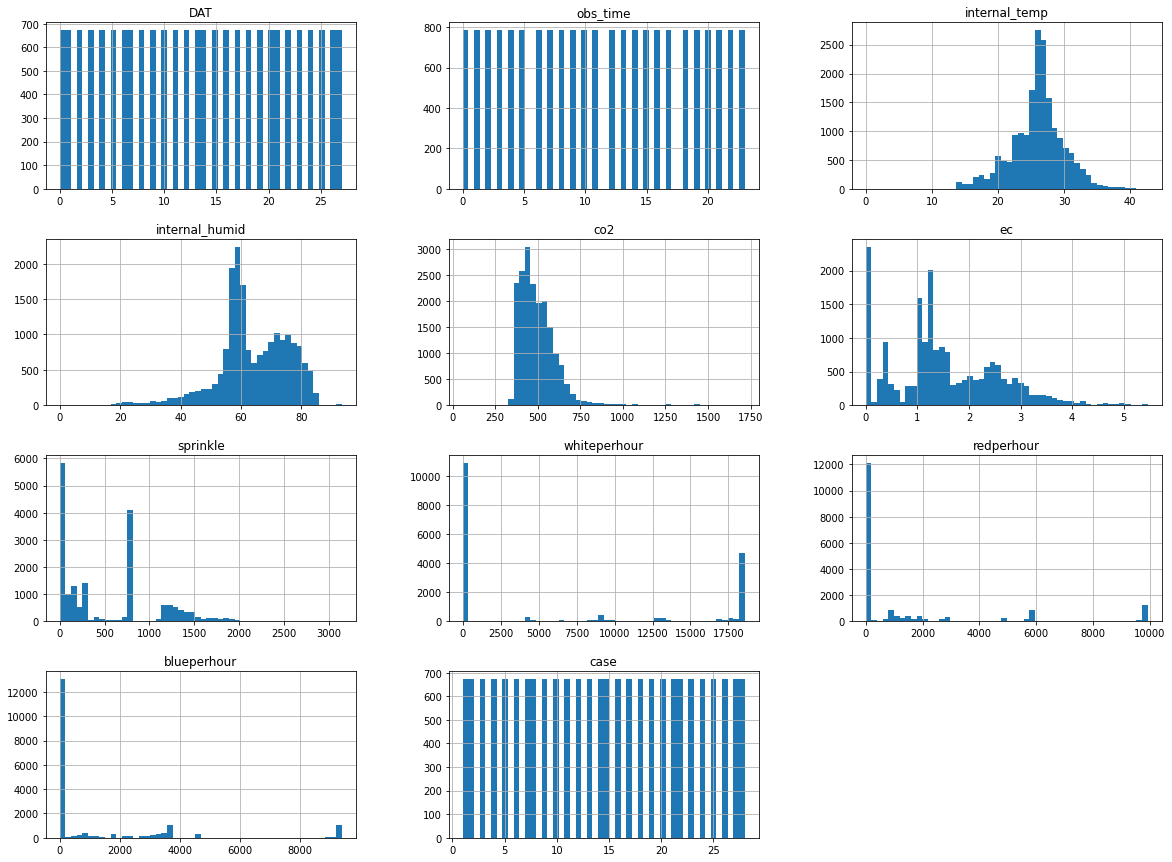

In [ ]:
import matplotlib.pyplot as plt
input_df_total.hist(bins=50, figsize=(20,15))
plt.show()

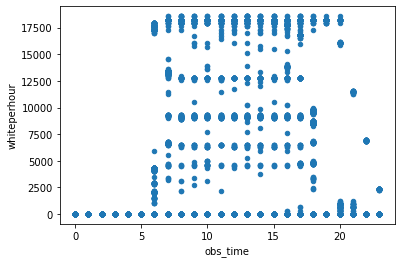

In [ ]:
input_df_total.plot(kind="scatter", x="obs_time", y='whiteperhour')

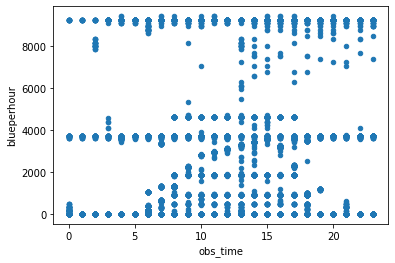

In [ ]:
input_df_total.plot(kind="scatter", x="obs_time", y='blueperhour')

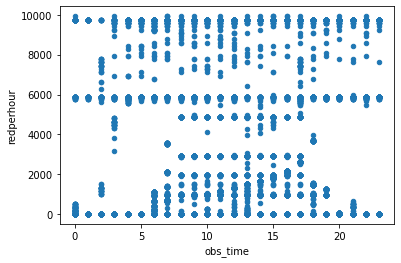

In [ ]:
input_df_total.plot(kind="scatter", x="obs_time", y='redperhour')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
input_df_total.iloc[:, :-1] = scaler.fit_transform(input_df_total.iloc[:, :-1].copy())
input_df_total

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,case
0,0.0,0.000000,0.593293,0.876647,0.287477,0.257663,0.000000,0.000000,0.0,0.0,1
1,0.0,0.043478,0.602213,0.870533,0.283053,0.257949,0.040075,0.000000,0.0,0.0,1
2,0.0,0.086957,0.592668,0.872755,0.285553,0.257567,0.000000,0.000000,0.0,0.0,1
3,0.0,0.130435,0.594583,0.871969,0.293250,0.257526,0.040075,0.000000,0.0,0.0,1
4,0.0,0.173913,0.595443,0.872880,0.301117,0.258328,0.000000,0.000000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
667,1.0,0.826087,0.610412,0.629209,0.234579,0.218847,0.000000,0.000667,0.0,0.0,28
668,1.0,0.869565,0.641171,0.625317,0.234992,0.217999,0.040075,0.000000,0.0,0.0,28
669,1.0,0.913043,0.651567,0.628941,0.230610,0.217049,0.000000,0.000000,0.0,0.0,28
670,1.0,0.956522,0.667865,0.622621,0.227991,0.215964,0.000000,0.000000,0.0,0.0,28


In [ ]:
new_input_list = []
for case in range(1, 29):
    new_input_list.append(input_df_total.loc[input_df_total['case']==case, :'시간당청색광량'])
    
new_input_list[0]

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
0,0.0,0.000000,0.593293,0.876647,0.287477,0.257663,0.000000,0.000000,0.000000,0.0
1,0.0,0.043478,0.602213,0.870533,0.283053,0.257949,0.040075,0.000000,0.000000,0.0
2,0.0,0.086957,0.592668,0.872755,0.285553,0.257567,0.000000,0.000000,0.000000,0.0
3,0.0,0.130435,0.594583,0.871969,0.293250,0.257526,0.040075,0.000000,0.000000,0.0
4,0.0,0.173913,0.595443,0.872880,0.301117,0.258328,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
667,1.0,0.826087,0.724146,0.881146,0.244210,0.000000,0.080149,0.983333,0.098333,0.0
668,1.0,0.869565,0.681662,0.883842,0.286641,0.000000,0.040075,0.033333,0.003333,0.0
669,1.0,0.913043,0.662393,0.887359,0.304049,0.000000,0.000000,0.000000,0.000000,0.0
670,1.0,0.956522,0.656726,0.887520,0.312339,0.000000,0.040075,0.000000,0.000000,0.0


In [ ]:
new_target_list = []
for i in range(0, 28):
    target_df = pd.read_csv(all_target_list[i])
    target_df['diff'] = target_df['predicted_weight_g'].diff()
    target_df.loc[0, 'diff'] = target_df.loc[0, 'predicted_weight_g']
    # target_df.drop(columns=['predicted_weight_g'], inplace=True)
    # target_df.rename(columns={'diff':'predicted_weight_g'}, inplace=True)
    new_target_list.append(target_df)

In [ ]:
data_list = []
label_list = []

for input_df, target_df in tqdm(zip(new_input_list, new_target_list)):
    
    input_length = int(len(input_df)/24)
    target_length = int(len(target_df))
    
    for idx in range(target_length):
        time_series = input_df[24*idx:24*(idx+1)].values
        data_list.append(time_series)
    for label in target_df["diff"]:
        label_list.append(label)

x_data = np.array(data_list)
y_data = np.array(label_list)

x_data.shape, y_data.shape

0it [00:00, ?it/s]

((784, 24, 10), (784,))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)

In [ ]:
input_shape = (x_train[0].shape[0], x_train[0].shape[1])

model = Sequential()
model.add(Conv1D(32, 6, input_shape=input_shape))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(1, activation = 'relu'))

optimizer = tf.optimizers.Adam(0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_valid, y_valid),
          epochs=100, 
          batch_size=8,
        #   callbacks=[es],
         )

Epoch 1/100
79/79 [==============================] - 8s 30ms/step - loss: 13.1557 - mse: 13.1557 - val_loss: 7.6945 - val_mse: 7.6945
Epoch 2/100
79/79 [==============================] - 1s 12ms/step - loss: 9.2697 - mse: 9.2697 - val_loss: 7.1830 - val_mse: 7.1830
Epoch 3/100
79/79 [==============================] - 1s 12ms/step - loss: 8.8823 - mse: 8.8823 - val_loss: 7.1808 - val_mse: 7.1808
Epoch 4/100
79/79 [==============================] - 1s 12ms/step - loss: 9.0253 - mse: 9.0253 - val_loss: 7.3809 - val_mse: 7.3809
Epoch 5/100
79/79 [==============================] - 1s 12ms/step - loss: 8.6159 - mse: 8.6159 - val_loss: 6.5661 - val_mse: 6.5661
Epoch 6/100
79/79 [==============================] - 1s 12ms/step - loss: 8.3005 - mse: 8.3005 - val_loss: 6.3688 - val_mse: 6.3688
Epoch 7/100
79/79 [==============================] - 1s 12ms/step - loss: 8.1186 - mse: 8.1186 - val_loss: 6.1774 - val_mse: 6.1774
Epoch 8/100
79/79 [==============================] - 1s 12ms/step - loss: 

## Inference

In [ ]:
test_input_list = sorted(glob.glob(os.path.join(DATA_DIR, 'test_input', '*.csv')))
test_target_list = sorted(glob.glob(os.path.join(DATA_DIR, 'test_target', '*.csv')))
test_target_list

['/content/drive/MyDrive/데이콘/상추/data/test_target/TEST_01.csv',
 '/content/drive/MyDrive/데이콘/상추/data/test_target/TEST_02.csv',
 '/content/drive/MyDrive/데이콘/상추/data/test_target/TEST_03.csv',
 '/content/drive/MyDrive/데이콘/상추/data/test_target/TEST_04.csv',
 '/content/drive/MyDrive/데이콘/상추/data/test_target/TEST_05.csv']

In [ ]:
for test_input_path, test_target_path in zip(test_input_list, test_target_list):
    input_df = pd.read_csv(test_input_path)
    input_df = input_df[[col for col in input_df.columns if not '누적' in col]]
    input_df['obs_time'] = [ num for num in range(0, 24) ] * 28
    input_df.drop(columns=['시간당총광량'], inplace=True)

    input_df.loc[input_df['시간당분무량'] < 0, '시간당분무량' ] = (-1) * input_df.loc[input_df['시간당분무량'] < 0, '시간당분무량' ]
    input_df.loc[input_df['시간당백색광량'] < 0,  '시간당백색광량'] = np.nan
    input_df.loc[input_df['시간당적색광량'] < 0,  '시간당적색광량'] = np.nan
    input_df.loc[input_df['시간당청색광량'] < 0,  '시간당청색광량'] = np.nan
    input_df['시간당백색광량'] = input_df['시간당백색광량'].interpolate()
    input_df['시간당적색광량'] = input_df['시간당적색광량'].interpolate()
    input_df['시간당청색광량'] = input_df['시간당청색광량'].interpolate()

    input_df.iloc[:, :] = scaler.transform(input_df.iloc[:, :].copy())   

    input_length = int(len(input_df)/24)
    
    data_list = []
    for idx in range(28):
        time_series = input_df[24*idx:24*(idx+1)].values
        data_list.append(time_series)
        
    pred = model.predict(np.array(data_list)).tolist()  

    submit_df = pd.read_csv(test_target_path)
    print(submit_df.shape)
    submit_df['predicted_weight_g'] = np.ravel(pred)
    submit_df['predicted_weight_g'] = submit_df['predicted_weight_g'].cumsum()
    submit_df.to_csv(test_target_path, index=False)


1/1 [==============================] - 1s 1s/step
(28, 2)
1/1 [==============================] - 0s 21ms/step
(28, 2)
1/1 [==============================] - 0s 21ms/step
(28, 2)
1/1 [==============================] - 0s 22ms/step
(28, 2)
1/1 [==============================] - 0s 22ms/step
(28, 2)


## Submission

In [ ]:
import zipfile
os.chdir("./data/test_target/")
# print(os.getcwd())
submission = zipfile.ZipFile("../submission.zip", 'w')
for path in test_target_list:
    path = path.split('/')[-1]
    print(path)
    submission.write(path)
submission.close()

TEST_01.csv
TEST_02.csv
TEST_03.csv
TEST_04.csv
TEST_05.csv
